<a href="https://colab.research.google.com/github/egmmaita/KD-1st-assignment/blob/master/KD_1st_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import random
import os
import numpy as np
import seaborn as sns
import pandas as pd

# Data

In [ ]:
!mkdir data
!wget https://github.com/egmmaita/KD-1st-assignment/raw/master/data01.zip
!wget https://github.com/egmmaita/KD-1st-assignment/raw/master/data02.zip
!wget https://github.com/egmmaita/KD-1st-assignment/raw/master/data03.zip
!unzip -q data01.zip -d data
!unzip -q data02.zip -d data
!unzip -q data03.zip -d data
!rm data01.zip data02.zip data03.zip

--2021-04-21 11:30:48--  https://github.com/egmmaita/KD-1st-assignment/raw/master/data01.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egmmaita/KD-1st-assignment/master/data01.zip [following]
--2021-04-21 11:30:48--  https://raw.githubusercontent.com/egmmaita/KD-1st-assignment/master/data01.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98562529 (94M) [application/zip]
Saving to: ‘data01.zip’

data01.zip          100%[===================>]  94.00M   161MB/s    in 0.6s    

2021-04-21 11:30:52 (161 MB/s) - ‘data01.zip’ saved [98562529/98562529]

--2021-04-21 11:30:52--  https://github.

Number of classes : 8
---------------------------------
    class     |  number of images
---------------------------------
pliers                        397
pebbles                       607
gasoline can                  240
rope                          332
toolbox                       431
wrench                       1479
hammer                       1667
screw driver                 1915
---------------------------------
Total number of images :     7068
---------------------------------


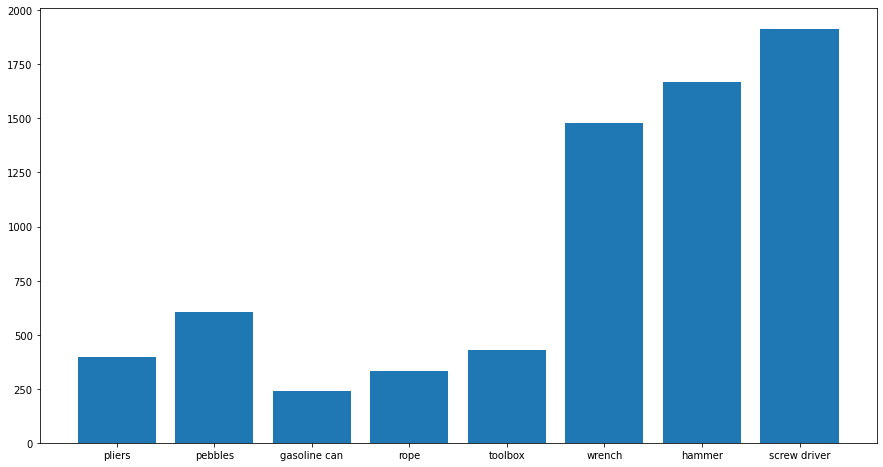

-------------------------------------
Average dimensions (W x H): 282 x 339
Minimum width: 88
Minimum height: 36
Maximum width: 6720
Maximum height: 8688


In [ ]:
dest_dir = "/content/data"
num_classes = len(os.listdir(dest_dir))
print(f"Number of classes : {num_classes}")
class_directories = [x.path for x in os.scandir(dest_dir)]
lengths = []
Classes = []
widths = []
heights = []
print('---------------------------------')
print("    class     |  number of images")
print('---------------------------------')
for class_directory in class_directories:
  Class = os.path.basename(class_directory)
  length = len([image for image in os.listdir(class_directory)])
  image_paths = [image.path for image in os.scandir(class_directory)]
  for image_path in image_paths:
    image = Image.open(image_path)
    widths.append(image.size[0])
    heights.append(image.size[1])
  print('{:<12}  {:>19}'.format(Class, length))
  Classes.append(Class)
  lengths.append(length)
print('---------------------------------')
print('Total number of images : {:>8}'.format(sum(lengths)))
print('---------------------------------')
plt.figure(figsize=(15,8))
plt.bar(np.arange(len(Classes)), lengths)
plt.xticks(np.arange(len(Classes)), Classes)
plt.show()
print("-------------------------------------")
print(f"Average dimensions (W x H): {round(sum(heights)/len(heights))} x {round(sum(widths)/len(widths))}")
print(f"Minimum width: {min(widths)}")
print(f"Minimum height: {min(heights)}")
print(f"Maximum width: {max(widths)}")
print(f"Maximum height: {max(heights)}")

In [ ]:
class MyDataset(Dataset):
  def __init__(self, dset_dir, transforms=T.Compose([])):
    self.dset_dir = Path(dset_dir)
    self.transforms = transforms
    self.files = []
    folders = sorted(os.listdir(self.dset_dir))
    for folder in folders:
      class_idx = folders.index(folder)
      folder_dir = self.dset_dir/folder
      files = os.listdir(folder_dir)
      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])
    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [ ]:
transforms = T.Compose([
        T.Resize((300,300)),
        T.RandomCrop((224,224)),
        T.ToTensor(),
        T.Normalize(0.5, 0.5),
        T.RandomHorizontalFlip(p=0.4), 
        T.RandomVerticalFlip(p=0.4)
    ])

In [ ]:
data = MyDataset(dest_dir,transforms=transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example :


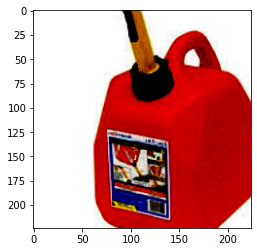

In [ ]:
example, _ = data[5]
print("Example :")
plt.imshow(example.permute(1, 2, 0))

In [ ]:
n = len(data)
idx = list(range(n))

random.seed(0)
random.shuffle(idx)
test_frac = 0.1
num_test = int(n * test_frac) 
num_train = n - 2*num_test

train_idx = idx[:num_train]
val_idx = idx[num_train : num_train+num_test]
test_idx = idx[num_train+num_test :]

print(f"{len(train_idx)} samples used as train set")
print(f"{len(val_idx)} samples used as validation set")
print(f"{len(test_idx)} samples used as test set")

train_set = Subset(data, train_idx)
val_set = Subset(data, val_idx)
test_set = Subset(data, test_idx)

5656 samples used as train set
706 samples used as validation set
706 samples used as test set


In [ ]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=8, shuffle=True, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, drop_last=False, num_workers=2)

loaders = {"train": train_loader,
           "val" : val_loader,
           "test": test_loader}

# Classification

In [ ]:
class MyCNN(nn.Module):
  def __init__(self, use_norm=False):
    super().__init__()
    self.convolution = nn.Sequential(
      # 1
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=2),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
    )
    self.classifier = nn.Sequential(
        nn.Linear(2048, 2048),
        nn.ReLU(),
        nn.Linear(2048,8)
    )
  def forward(self, x):
    b, _, _, _ = x.shape
    features_extracted = self.convolution(x)
    return self.classifier(features_extracted.view(b, -1))

In [ ]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
 
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
 
        best_val_accuracy = 0
        nb_classes = 8
 
        for epoch in range(epochs):
            print("---------------------------------------------------------------------------------")
            print(f"Epoch {epoch+1} ...")
 
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
 
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                
                confusion_matrix = torch.zeros(nb_classes, nb_classes)
 
                for (input, labels) in loaders[split]:
                    input = input.to(dev)
                    labels = labels.to(dev)
 
                    optimizer.zero_grad()
                    pred = net(input)
                    loss = criterion(pred, labels)
                    sum_loss[split] += loss.item()
 
                    if split == "train":
                        loss.backward()
                        optimizer.step()
 
                    _ , pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    sum_accuracy[split] += batch_accuracy
                    
                    if split=="test":
                      confusion_matrix[labels.view(-1).long(), pred_labels.view(-1).long()] += 1 ########################
 
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}


            if epoch_accuracy["val"] > best_val_accuracy:
              best_train_loss = epoch_loss['train']
              best_val_loss = epoch_loss['val']
              best_test_loss = epoch_loss['test']
              best_train_accuracy = epoch_accuracy['train']
              best_val_accuracy = epoch_accuracy['val']
              best_test_accuracy = epoch_accuracy['test']
              best_confusion_matrix = confusion_matrix

            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
 
            print(f"TrL = {epoch_loss['train']:.4f},",
                  f"TrA = {epoch_accuracy['train']:.4f},",
                  f"VL = {epoch_loss['val']:.4f},",
                  f"VA = {epoch_accuracy['val']:.4f},",
                  f"TeL = {epoch_loss['test']:.4f},",
                  f"TeA = {epoch_accuracy['test']:.4f}")
    
    except KeyboardInterrupt:
        print("*********************************************************************************")
        print("*******************************    Interrupted    *******************************")
        print("*********************************************************************************")
    
    finally:
        plt.figure(figsize=(11,8))
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(11,8))
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(np.around(np.array(history_accuracy[split]),2), label=split)
        plt.legend()
        plt.show()
 
        print("---------------------------------------------------------------------------------")
        print(f"Best model performance after {epoch+1} epochs: ")
        print(f"TrL = {best_train_loss:.4f},",
              f"TrA = {best_train_accuracy:.4f},",
              f"VL = {best_val_loss:.4f},",
              f"VA = {best_val_accuracy:.4f},",
              f"TeL = {best_test_loss:.4f},",
              f"TeA = {best_test_accuracy:.4f}")
        print("---------------------------------------------------------------------------------")
        plt.figure(figsize=(12,8))
        classes = sorted(os.listdir(dest_dir))
        heatmap = sns.heatmap(pd.DataFrame(best_confusion_matrix, index=classes, columns=classes).astype(int),
                              annot=True,
                              fmt="d")
        heatmap.set_title("Confusion matrix on test set")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=9)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=9)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        print("Per-class accuracy on test set:")
        print("-----------------------------------------")
        per_class = best_confusion_matrix.diag()/best_confusion_matrix.sum(1)
        for i,j in zip(classes, per_class):
          print('{:<12}  {:>19}'.format(i,round(j.item(),2)))
        print("-----------------------------------------")

GPU: Tesla K80
MyCNN(
  (convolution): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): AdaptiveMaxPool2d(output_size=2)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=8, bias=True)
  )
)
---------------------------------------------------------------------------------
Epoch 1 ...
TrL = 1.8377, TrA = 0.2698, VL = 1.8202, VA = 0.2865, TeL = 1.7953, TeA = 0.3062
----------------

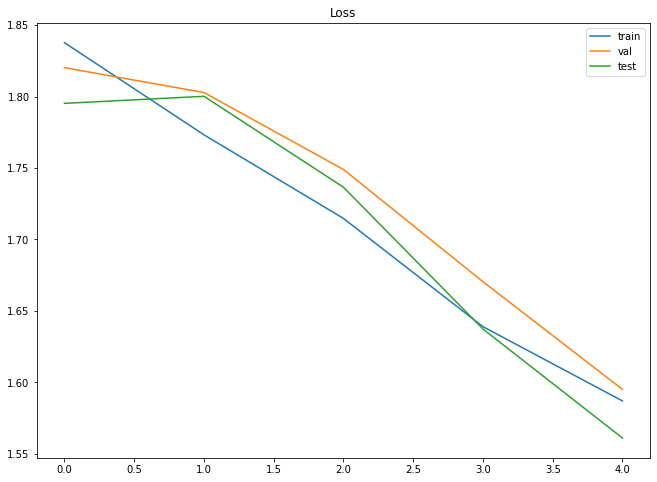

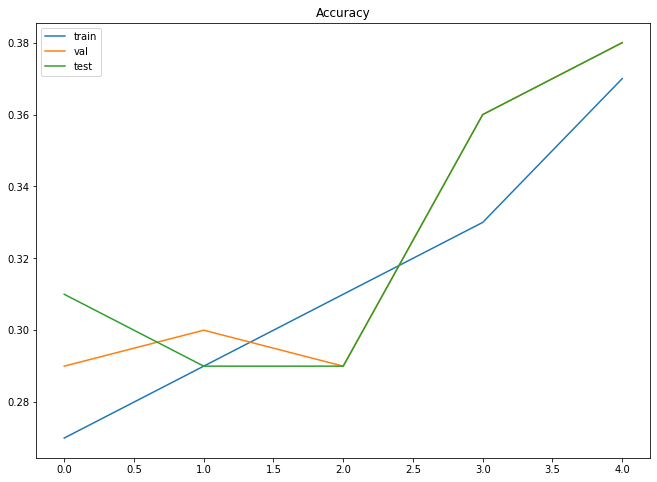

---------------------------------------------------------------------------------
Best model performance after 6 epochs: 
TrL = 1.5869, TrA = 0.3676, VL = 1.5950, VA = 0.3806, TeL = 1.5610, TeA = 0.3778
---------------------------------------------------------------------------------
Per-class accuracy on test set:
-----------------------------------------
gasoline can                  0.5
hammer                       0.21
pebbles                      0.27
pliers                       0.13
rope                          0.0
screw driver                 0.66
toolbox                      0.32
wrench                       0.32
-----------------------------------------


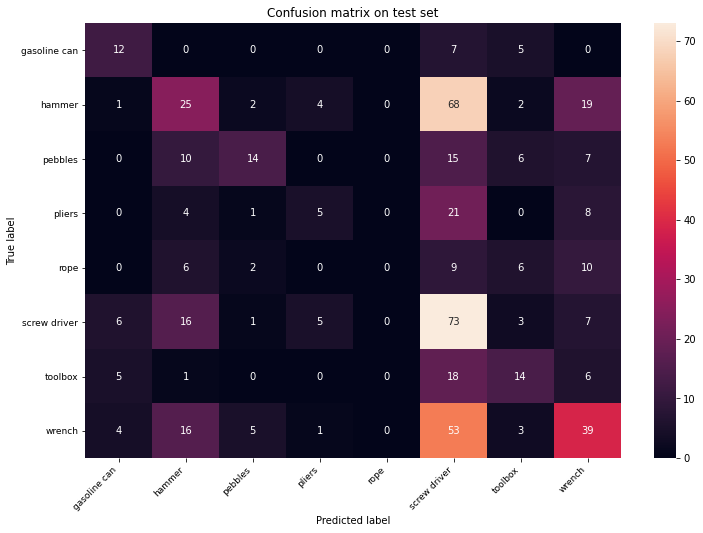

In [ ]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
  print(f"GPU: {torch.cuda.get_device_name(0)}")
 
net = MyCNN()
optimizer = optim.SGD(net.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
 
train(net, loaders, optimizer, criterion, dev=dev)